In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats

from matplotlib import pyplot as plt

from statsforecast.models import Naive

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

/home/grc/arep/time_series/lib/python3.10/site-packages/statsforecast/core.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


### 1.0. Predicting Intervals

Um "Point Forecast" é resultado da média da distribuição de previsão citada no capítulo 1. Consequentemente podemos pegar essa distribuição de previsão e utilizar para incluir um intervalo de confiança para a previsão.

Para os modelos de previsão baseline, já existem alguns benchmark que podemos usar e derivar o desvio padrão matematicamente, então não precisamos ir mais a fundo na matemática para os demais modelos e utilizar esses já existentes para as previsões simples. Entretanto, é necessário que as assumptions de não correlação e de normalidade estejam satisfeitas nos erros / resíduos antes de usar esses métodos.

$\hat{\sigma} = \sqrt{\frac{1}{T - K - M} \times \sum_{t=1}^{T} e_t^{2}}$

1. Mean: $\hat{\sigma}_h = \hat{\sigma} \times \sqrt{1 + 1 / T}$
2. Naive: $\hat{\sigma}_h = \hat{\sigma} \times \sqrt{h}$
3. SNaive: $\hat{\sigma}_h = \hat{\sigma} \times \sqrt{k + 1}$
4. Drift: $\hat{\sigma}_h = \hat{\sigma} \times \sqrt{h (1 + h / (T - 1))}$

Onde:

- $\hat{\sigma}_h$: Desvio padrão das previsões em h passos a frente.
- $\hat{\sigma}$: Desvio padrão residual, pela primeira fórmula.
- $T$: Tamanho da série.
- $K$: Número de parâmetros estimados.
- $M$: Números de dados faltantes nos resíduos (Se for Naive, M=1 pois não tem como prever o primeiro valor da série).
- $h$: Horizonte de previsão, h passos a frente de previsão, se você prever 3 valores no futuro, então, $h = 3$.

Primeiro calcula-se o $\hat{\sigma}$, seleciona um intervalo de confiança da tabela do livro, por exemplo, 1.96 para 95% e calcula tudo.

#### 1.1. Google Stock Price

In [2]:
df = pd.read_csv("../data/gafa_stock.csv", index_col=[0])

df = df[df["Symbol"] == "GOOG"].reset_index(drop=True)

df["Date"] = pd.to_datetime(df["Date"])

df = df[(df["Date"] < "2016-01-01") & (df["Date"] >= "2015-01-01")]

df.reset_index(drop=True, inplace=True)

In [21]:
df["naive"] = df["Close"].shift(1)

df["resid"] = df["Close"] - df["naive"]

yt = df.loc[df.Date == df.Date.max(), "Close"].values.tolist()

forecast = pd.DataFrame(
    pd.date_range(
        df.Date.max() + pd.offsets.DateOffset(days=1),
        df.Date.max() + pd.offsets.DateOffset(days=31),
        freq="D"
    )
)

forecast.columns = ["Date"]

forecast["Naive"] = forecast.shape[0] * yt

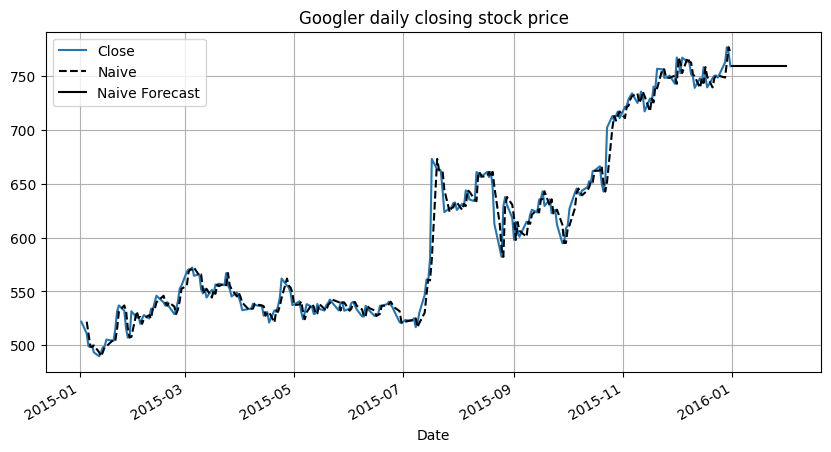

In [4]:
ax = df.plot(
    x="Date", y="Close", title="Googler daily closing stock price",
    figsize=(10, 5)
)
ax = df.plot(
    x="Date", y="naive", label="Naive",
    color="k", linestyle="--", ax=ax
)
forecast.plot(
    x="Date", y="Naive", color="k",
    grid=2, ax=ax, label="Naive Forecast"
);

##### 1.1.1. Random Variables

In [5]:
df.head()

,Symbol,Date,Open,High,Low,Close,Adj_Close,Volume,naive,resid
0,GOOG,2015-01-02,526.114746,528.362366,521.231628,521.937744,521.937744,1447600.0,NaN,NaN
1,GOOG,2015-01-05,520.396240,521.460388,510.252045,511.057617,511.057617,2059800.0,521.937744,-10.880127
2,GOOG,2015-01-06,512.181458,513.350037,498.307800,499.212799,499.212799,2899900.0,511.057617,-11.844818
3,GOOG,2015-01-07,504.225220,504.467896,496.915436,498.357513,498.357513,2065100.0,499.212799,-0.855286
4,GOOG,2015-01-08,495.264526,500.724487,488.312805,499.928864,499.928864,3353600.0,498.357513,1.571351


In [6]:
T = len(df) # Tamanho da Serie
M = 1       # O primeiro valor é NaN
K = 0       # Nenhum parametro foi estimado no Naive

In [7]:
sigma_hat = np.sqrt((1 / (T - M - K)) * np.sum(df["resid"] ** 2))
sigma_hat = np.round(sigma_hat, 2)

upper_95_bound = yt[0] + 1.96 * sigma_hat
lower_95_bound = yt[0] - 1.96 * sigma_hat

upper_80_bound = yt[0] + 1.28 * sigma_hat
lower_80_bound = yt[0] - 1.28 * sigma_hat

print(sigma_hat)
print([lower_95_bound, upper_95_bound])
print([lower_80_bound, upper_80_bound])

11.19
[736.947605, 780.812405]
[744.5568049999999, 773.203205]


Como YT nunca vai mudar, vai ser sempre o mesmo, que é o ultimo valor de YT, o intervalo de confiança vai ser o mesmo para todo o horizonte de previsão, no livro cita que é necessário uma função não linear.

Somente para ter esse fenômeno de confiança ao longo do tempo e não precisar calcular muita coisa, irei somar o index da previsão da linha com um número aleatório somente para ter esse intervalo maior como esta no livro.

Entretanto, uma abordagem mais inteligêNte é utilizar **amostragem com repetição** dos valores dos resid, isso o livro aborda também, dessa forma podemos com uma amostra muito grande montar a distribuição normal quase que perfeita da distribuição original de previsão a fim de com essa amostragem desenvolver o intervalo de confiança mais apropriado.

Outra abordagem é utilizar cálculos de confiança de distribuições de probabilidade.

Irei experimentar as duas abordagens, manualmente e usando o statsforecast.

In [8]:
np.random.seed(123456789)

In [9]:
confidence_idx = np.array([k + np.random.random() for k in forecast.index.tolist()])

lower_95_bound =  lower_95_bound - np.array(confidence_idx)
upper_95_bound =  upper_95_bound + np.array(confidence_idx)

lower_80_bound =  lower_80_bound - np.array(confidence_idx)
upper_80_bound =  upper_80_bound + np.array(confidence_idx)

In [10]:
forecast["lower_95"] = lower_95_bound
forecast["upper_95"] = upper_95_bound
forecast["lower_80"] = lower_80_bound
forecast["upper_80"] = upper_80_bound

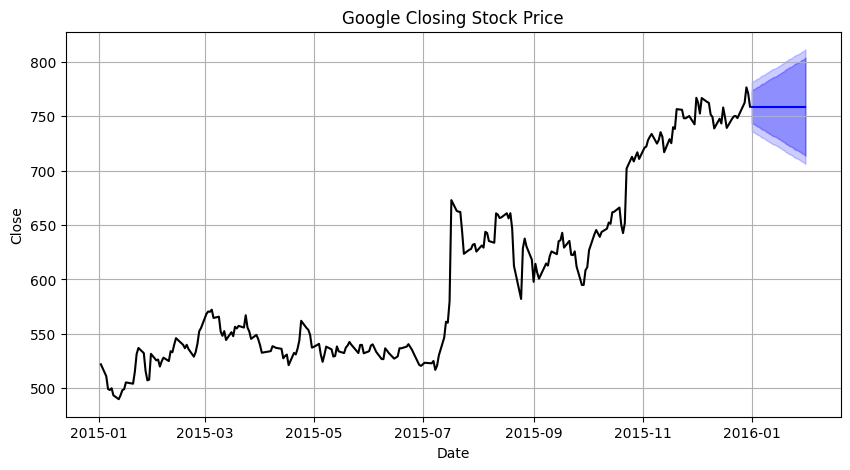

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(df, x="Date", y="Close", ax=ax, color="k")
sns.lineplot(forecast, x="Date", y="Naive", ax=ax, color="b")

ax.fill_between(
    x=forecast["Date"],
    y1=forecast["lower_80"],
    y2=forecast["upper_80"],
    color="b",
    alpha=0.3
)

ax.fill_between(
    x=forecast["Date"],
    y1=forecast["lower_95"],
    y2=forecast["upper_95"],
    color="b",
    alpha=0.2
)

ax.set_title("Google Closing Stock Price")
ax.grid(2)

##### 1.1.2. Z Scores

Usando o StatsForecast para treinar o Naive.

In [ ]:
naive = Naive()
naive = naive.fit(df["Close"].to_numpy())

ff = pd.DataFrame(naive.predict(h=forecast.Date.nunique(), level=[80, 95]))

ff["Date"] = forecast["Date"]

forecast = ff.copy()

Os intervalo do point forecast do primeiro valor previsto estão quase iguais com o valor do Statsforecast, agora precisamos aprender como gerar multiplos pontos para o intervalo de previsão.

In [55]:
sigma_hat = np.sqrt((1 / (T - M - K)) * np.sum(df["resid"] ** 2))
sigma_hat = np.round(sigma_hat, 2)

upper_95_bound = yt[0] + 1.96 * sigma_hat
lower_95_bound = yt[0] - 1.96 * sigma_hat

upper_80_bound = yt[0] + 1.28 * sigma_hat
lower_80_bound = yt[0] - 1.28 * sigma_hat

print(sigma_hat)
print([lower_95_bound, upper_95_bound])
print([lower_80_bound, upper_80_bound])

11.19
[736.947605, 780.812405]
[744.5568049999999, 773.203205]


In [56]:
forecast.head()

,mean,lo-80,lo-95,hi-80,hi-95,Date
0,758.880005,744.539977,736.948825,773.220033,780.811185,2016-01-01
1,758.880005,738.600143,727.864632,779.159867,789.895378,2016-01-02
2,758.880005,734.042348,720.894086,783.717662,796.865923,2016-01-03
3,758.880005,730.199949,715.017644,787.560061,802.742365,2016-01-04
4,758.880005,726.814727,709.840395,790.945282,807.919615,2016-01-05


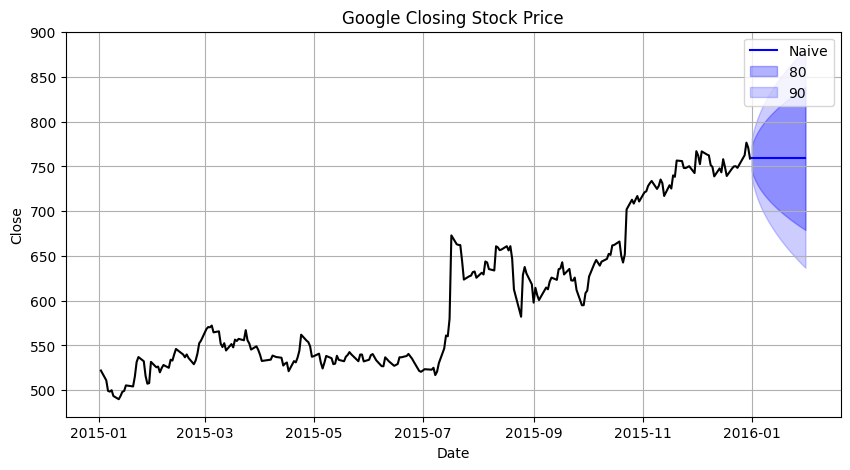

In [58]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(df, x="Date", y="Close", ax=ax, color="k")
sns.lineplot(forecast, x="Date", y="mean", label="Naive", ax=ax, color="b")

ax.fill_between(
    x=forecast["Date"],
    y1=forecast["lo-80"],
    y2=forecast["hi-80"],
    color="b",
    label="80",
    alpha=0.3
)

ax.fill_between(
    x=forecast["Date"],
    y1=forecast["lo-95"],
    y2=forecast["hi-95"],
    color="b",
    label="90",
    alpha=0.2
)

ax.set_title("Google Closing Stock Price")
ax.grid(2)
ax.legend();

O Sigma do modelo fitado é exatamente igual ao sigma obtido pelo livro.

Irei seguir os steps do código a fim de obter os mesmos resultados.

In [16]:
naive.model_["sigma"], sigma_hat

(11.189583315095275, 11.19)

Para dar sequencia, irei definir algumas coisas.

In [17]:
# Os níveis de confiança que quero obter
# estão no intervalo de 80% e 95%
level = [.80, .95]

# Previsão em H passos
h = forecast.Date.nunique()

# O último valor observado, pois estamos no Naive
yt = df[df.Date == df["Date"].max()]["Close"].values

# Uma lista de H steps no futuro
# com o tamanho do dataset começanco em 1
hsteps = forecast.index.to_numpy() + 1

# Para que o intervalo não fique gigantesco
# irei extrair a raiz quadrada dos steps
# Mas poderia ser outra operação.
sigmah = sigma_hat * np.sqrt(hsteps)
sigmal = sigma_hat * np.log1p(hsteps)

Agora, para extrair o nível de confiança sem precisar utilizar numeros aleatórios ou amostragem, é necessário utilizar a curva normal padrão, onde a média é igual a zero e o desvio padrão é igual a 1.

- A média sendo zero é uma das hipóteses relacionadas a os resíduos, e a segunda hipótese é que a variação é constante.

Nós ja conhecemos a média e o desvio padrão, onde eles são conhecidos, assim estamos considerando em utilizar a distribuição normal com média e variancia conhecidas.

Por exemplo, para a confiança de 90%, existe um alpha de 10%.

Fazendo a formuleta de bolso para encontrar o valor critico $0.5 - \frac{\alpha}{2}$, obtemos 0.45, com esse valor conseguimos, olhando na tabela, selecionar o z score ou z critico que é 1.6 + 0.04.

In [1]:
confidence = .90
alpha = 1 - .90

table_idx = 0.5 - alpha / 2

print(f"Olhando a tabela, procurando pelo valor: {table_idx}, obtemos: {1.6 + 0.04:.2f}")

Olhando a tabela, procurando pelo valor: 0.45, obtemos: 1.64


Para pegar no python esse mesmo valor, usamos o scipy.stats.norm.ppf. Entretanto, tem que somar mais 0.5 na função.
Quero ser fiel a fórmula que aprendi, então irei somar o 0.5 no ppf.

In [22]:
zscore = stats.norm.ppf(0.5 + 0.45)

zscore

1.6448536269514722

Levando em conta os intervalos previamente definidos.

In [23]:
alpha = 1 - np.array(level)

table_idx = 0.5 - alpha / 2

table_idx

array([0.4  , 0.475])

In [24]:
zscores = stats.norm.ppf(0.5 + table_idx)

zscores

array([1.28155157, 1.95996398])

In [25]:
dfz = pd.DataFrame(np.array([[zscore for i in range(h)] for zscore in zscores])).T
dfz.columns = [f"C-{int(k * 100)}" for k in level]

In [26]:
dfz.head()

,C-80,C-95
0,1.281552,1.959964
1,1.281552,1.959964
2,1.281552,1.959964
3,1.281552,1.959964
4,1.281552,1.959964


In [31]:
dfz["L-95"] = yt - dfz["C-95"] * sigmah
dfz["U-95"] = yt + dfz["C-95"] * sigmah
dfz["L-80"] = yt - dfz["C-80"] * sigmah
dfz["U-80"] = yt + dfz["C-80"] * sigmah

In [32]:
dfz.head()

,C-80,C-95,L-95,U-95,L-80,U-80
0,1.281552,1.959964,736.948008,780.812002,744.539443,773.220567
1,1.281552,1.959964,727.863477,789.896533,738.599388,779.160622
2,1.281552,1.959964,720.892672,796.867338,734.041423,783.718587
3,1.281552,1.959964,715.016011,802.743999,730.198881,787.561129
4,1.281552,1.959964,709.838569,807.921441,726.813533,790.946477


In [36]:
forecast = forecast[["Date"]]

forecast["Mean"] = yt[0]

forecast = pd.concat([forecast, dfz.iloc[:, 2:]], axis=1)

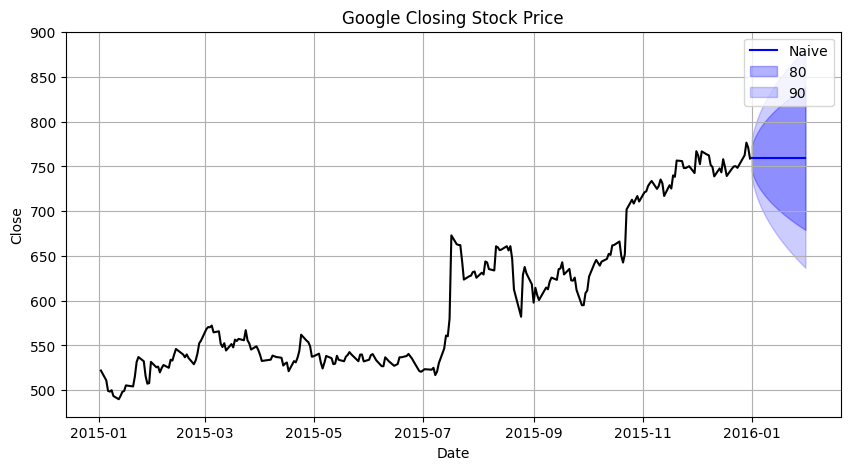

In [53]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(df, x="Date", y="Close", ax=ax, color="k")
sns.lineplot(forecast, x="Date", y="Mean", label="Naive", ax=ax, color="b")

ax.fill_between(
    x=forecast["Date"],
    y1=forecast["L-80"],
    y2=forecast["U-80"],
    color="b",
    label="80",
    alpha=0.3
)

ax.fill_between(
    x=forecast["Date"],
    y1=forecast["L-95"],
    y2=forecast["U-95"],
    color="b",
    label="90",
    alpha=0.2
)

ax.set_title("Google Closing Stock Price")
ax.grid(2)
ax.legend();

In [60]:
dfz["L-95"] = yt - dfz["C-95"] * sigmal
dfz["U-95"] = yt + dfz["C-95"] * sigmal
dfz["L-80"] = yt - dfz["C-80"] * sigmal
dfz["U-80"] = yt + dfz["C-80"] * sigmal

forecast = forecast[["Date"]]

forecast["Mean"] = yt[0]

forecast = pd.concat([forecast, dfz.iloc[:, 2:]], axis=1)

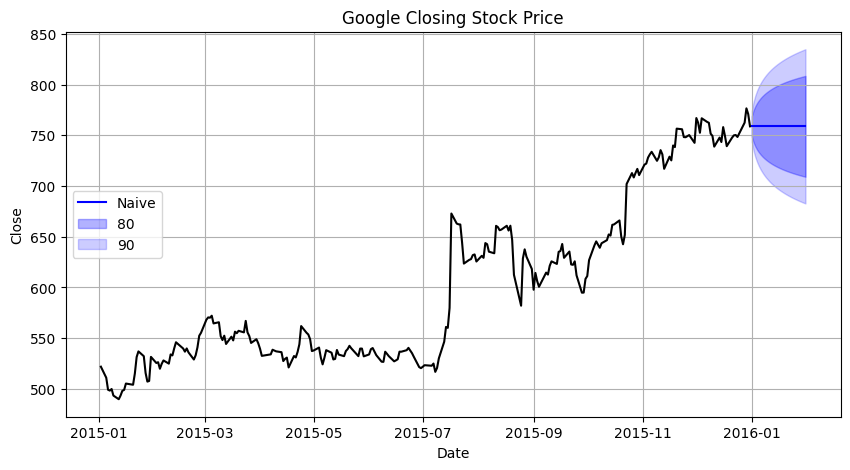

In [62]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(df, x="Date", y="Close", ax=ax, color="k")
sns.lineplot(forecast, x="Date", y="Mean", label="Naive", ax=ax, color="b")

ax.fill_between(
    x=forecast["Date"],
    y1=forecast["L-80"],
    y2=forecast["U-80"],
    color="b",
    label="80",
    alpha=0.3
)

ax.fill_between(
    x=forecast["Date"],
    y1=forecast["L-95"],
    y2=forecast["U-95"],
    color="b",
    label="90",
    alpha=0.2
)

ax.set_title("Google Closing Stock Price")
ax.grid(2)
ax.legend(loc="center left");

##### 1.1.3. Bootstraping

Tudo começou com uma regrinha matemática de isolar $y_t$ da fórmula: $e_t = y_t - \hat{y_t}$, obtendo: $y_t = \hat{y_t} + e_t$.

E reescrevendo, temos: $y^{*}_{T+1} = y_T + e^{*}_{T+1}$, onde a estrela (*) representa uma amostra aleatoria de erros passados.

Mas eu acho que no Python eu deveria chegar por outro approach.

In [53]:
dfs = df.copy()

dfs.dropna(inplace=True)

Fiz um filtro pegando apenas o ultimo mês para não correr o risco de algum valor muito do passado for amostrado.

In [61]:
dfs = dfs[dfs.Date >= "2015-12-01"]

In [70]:
forecast = pd.DataFrame(
    pd.date_range(
        df.Date.max() + pd.offsets.DateOffset(days=1),
        df.Date.max() + pd.offsets.DateOffset(days=31),
        freq="D"
    )
)

forecast.columns = ["Date"]

num_sims = 10

for simulation in range(1, num_sims + 1):
    
    sims = list()
    for i in range(1, len(forecast) + 1):    
        et = dfs["resid"].sample(1).to_numpy()
        yt = dfs["Close"].sample(1).to_numpy()

        yT = et + yt

        sims.append(yT[0])

    forecast[f"sim_{simulation}"] = sims
    

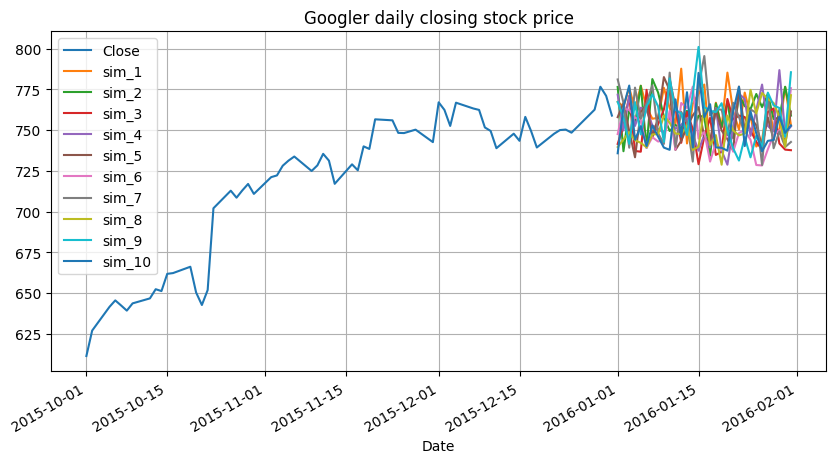

In [71]:
ax = df[df["Date"] >= "2015-10-01"].plot(
    x="Date", y="Close", title="Googler daily closing stock price",
    figsize=(10, 5)
)
forecast.plot(
    x="Date",
    grid=2, ax=ax, label="Naive Forecast"
);

In [73]:
forecast.head()

,Date,sim_1,sim_2,sim_3,sim_4,sim_5,sim_6,sim_7,sim_8,sim_9,sim_10
0,2016-01-01,767.349976,776.489991,741.489990,771.710022,757.920044,747.550048,781.080018,739.619996,767.229981,735.750000
1,2016-01-02,764.419984,737.010010,752.529968,749.739991,766.629944,763.090027,766.809998,744.210022,757.710022,764.150025
2,2016-01-03,775.940003,762.510010,770.830017,771.000000,749.429993,762.460023,739.179993,748.760010,741.490050,777.339966
3,2016-01-04,762.670044,753.430054,737.179993,752.529968,733.280029,757.670044,776.049987,743.740051,767.119996,744.030028
4,2016-01-05,777.200013,777.200013,736.720032,763.750000,761.159973,756.230042,756.970031,742.170044,747.310059,752.390015
